# Hyperparameter optimisation of a Gaussian Process

In [16]:
%pylab inline  
import GPy
import GPyOpt
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd

from numpy.random import seed
from scipy.stats import multivariate_normal as mvn

warnings.filterwarnings('ignore')
seed(12345)

Populating the interactive namespace from numpy and matplotlib


## Load the data

In [79]:
pr_df = pd.read_csv("data_single_uk_point.csv")

training_set = pr_df.iloc[0:80]
test_set = pr_df.iloc[80:100]

In [80]:
x_train = np.linspace(1, 80, 80)

# Renormalise it since they're all approximately *10^-5
y_train = (training_set["pr"].to_numpy())*10**5

x_test = np.linspace(80, 100, 20)
y_test = test_set["pr"].to_numpy()*10**5

x_train.shape, y_train.shape

((80,), (80,))

## Fit a GP to this data

In [81]:
kernel = GPy.kern.RBF(1, lengthscale=2.6, variance=3.5) + GPy.kern.StdPeriodic(1, lengthscale=1.0) * GPy.kern.PeriodicMatern32(1, lengthscale=10, variance=3.5)
model = GPy.models.GPRegression(x_train.reshape(-1, 1), y_train.reshape(-1, 1), kernel=kernel, normalizer= True, noise_var=0.05)

In [82]:
display(model)

GP_regression.,value,constraints,priors
sum.rbf.variance,3.5,+ve,
sum.rbf.lengthscale,2.6,+ve,
sum.mul.std_periodic.variance,1.0,+ve,
sum.mul.std_periodic.period,1.0,+ve,
sum.mul.std_periodic.lengthscale,1.0,+ve,
sum.mul.periodic_Matern32.variance,3.5,+ve,
sum.mul.periodic_Matern32.lengthscale,10.0,+ve,
sum.mul.periodic_Matern32.period,6.283185307179586,+ve,
Gaussian_noise.variance,0.05,+ve,


Find a measure of the loss, e.g. RMSE, using the default parameters.

In [83]:
x_all = np.linspace(1, 100, 100)
y_mean, y_std = model.predict(x_all.reshape(-1, 1))

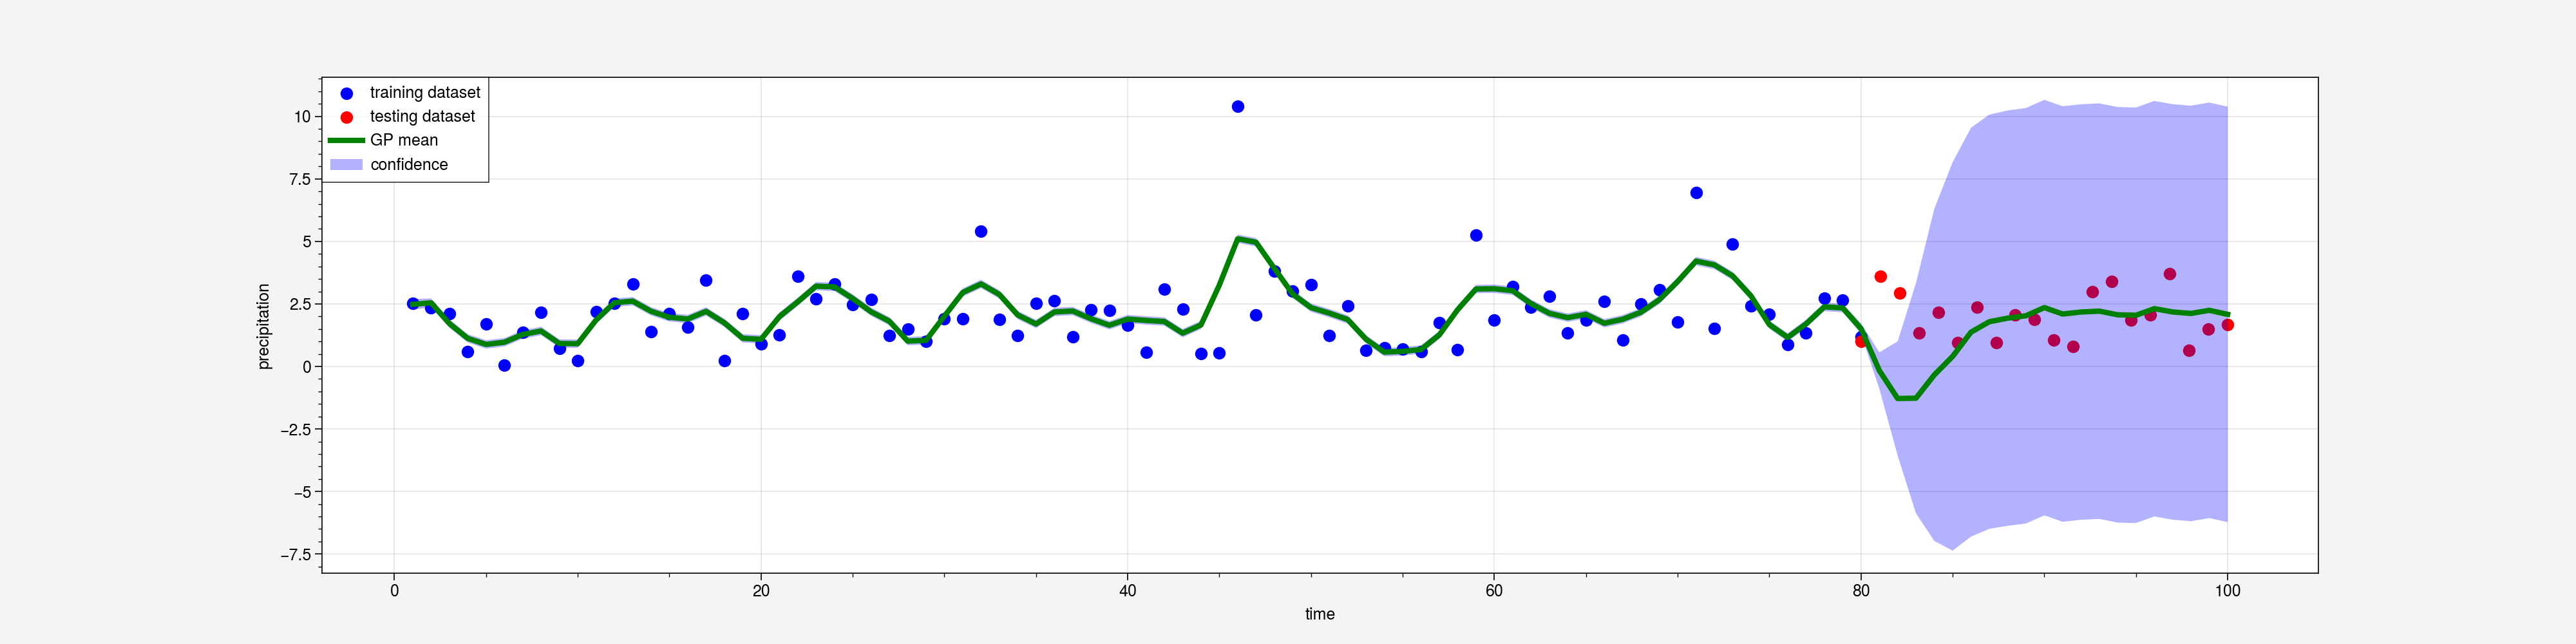

In [84]:
plt.figure(figsize=(20, 5), dpi=100)
plt.xlabel("time")
plt.ylabel("precipitation")
plt.scatter(x_train, y_train, lw=1, color="b", label="training dataset")
plt.scatter(x_test, y_test, lw=1, color="r", label="testing dataset")
plt.plot(x_all, y_mean, lw=3, color="g", label="GP mean")
plt.fill_between(x_all, (y_mean + y_std).reshape(y_mean.shape[0]), (y_mean - y_std).reshape(y_mean.shape[0]), facecolor="b", alpha=0.3, label="confidence")
plt.legend(loc="upper left")
plt.show()

In [85]:
# Make some predictions by drawing from the distributions 
# the GP has returned for all values (the first 80 were
# actually in the training set, the rest only test set.)
def draw_samples(y_mean, y_std):
    mean = y_mean.reshape(-1)
    cov = np.diag(y_std.reshape(-1))
    y_pred = mvn.rvs(mean, cov, 1)

    return y_pred

In [93]:
def fit_gp(x):
    # x are the hyperparameters: ls1, ls2, v1, v2.
    
    rmse = 0
    for i in range(x.shape[0]):
        # Create and train an SVR on this data.
        kernel = GPy.kern.RBF(1, lengthscale=x[i, 0], variance=x[i, 3]) + GPy.kern.StdPeriodic(1, lengthscale=x[i, 1]) * GPy.kern.PeriodicMatern32(1, lengthscale=x[i, 2], variance=x[i, 4])
        model = GPy.models.GPRegression(x_train.reshape(-1, 1), y_train.reshape(-1, 1), kernel=kernel, normalizer= True, noise_var=0.05)
        y_mean, y_std = model.predict(x_all.reshape(-1, 1))
        y_pred = draw_samples(y_mean, y_std)
        
        # Calculate RMSE — does it even make sense to use RMSE since
        # a GP doesn't make exact predictions, but specifies distributions
        # over functions?
        all_y = np.concatenate([y_train, y_test])
        rmse += np.sum(all_y - y_pred)

    return rmse

In [100]:
domain = [
    {'name': 'lengthscale1', 'type': 'continuous', 'domain': (0.,5.)},
    {'name': 'lengthscale2', 'type': 'continuous', 'domain': (0.,1.)},
    {'name': 'lengthscale3', 'type': 'continuous', 'domain': (0.,5.)},
    {'name': 'variance1', 'type': 'continuous', 'domain': (0.,1.)},
    {'name': 'variance2', 'type': 'continuous', 'domain': (0.,1.)}]

We, then, create the GPyOpt object and run the optimization procedure. It might take a while.

In [101]:
opt = GPyOpt.methods.BayesianOptimization(f = fit_gp,            # function to optimize       
                                          domain = domain,         # box-constraints of the problem
                                          acquisition_type ='LCB',       # LCB acquisition
                                          acquisition_weight = 0.1)   # Exploration exploitation

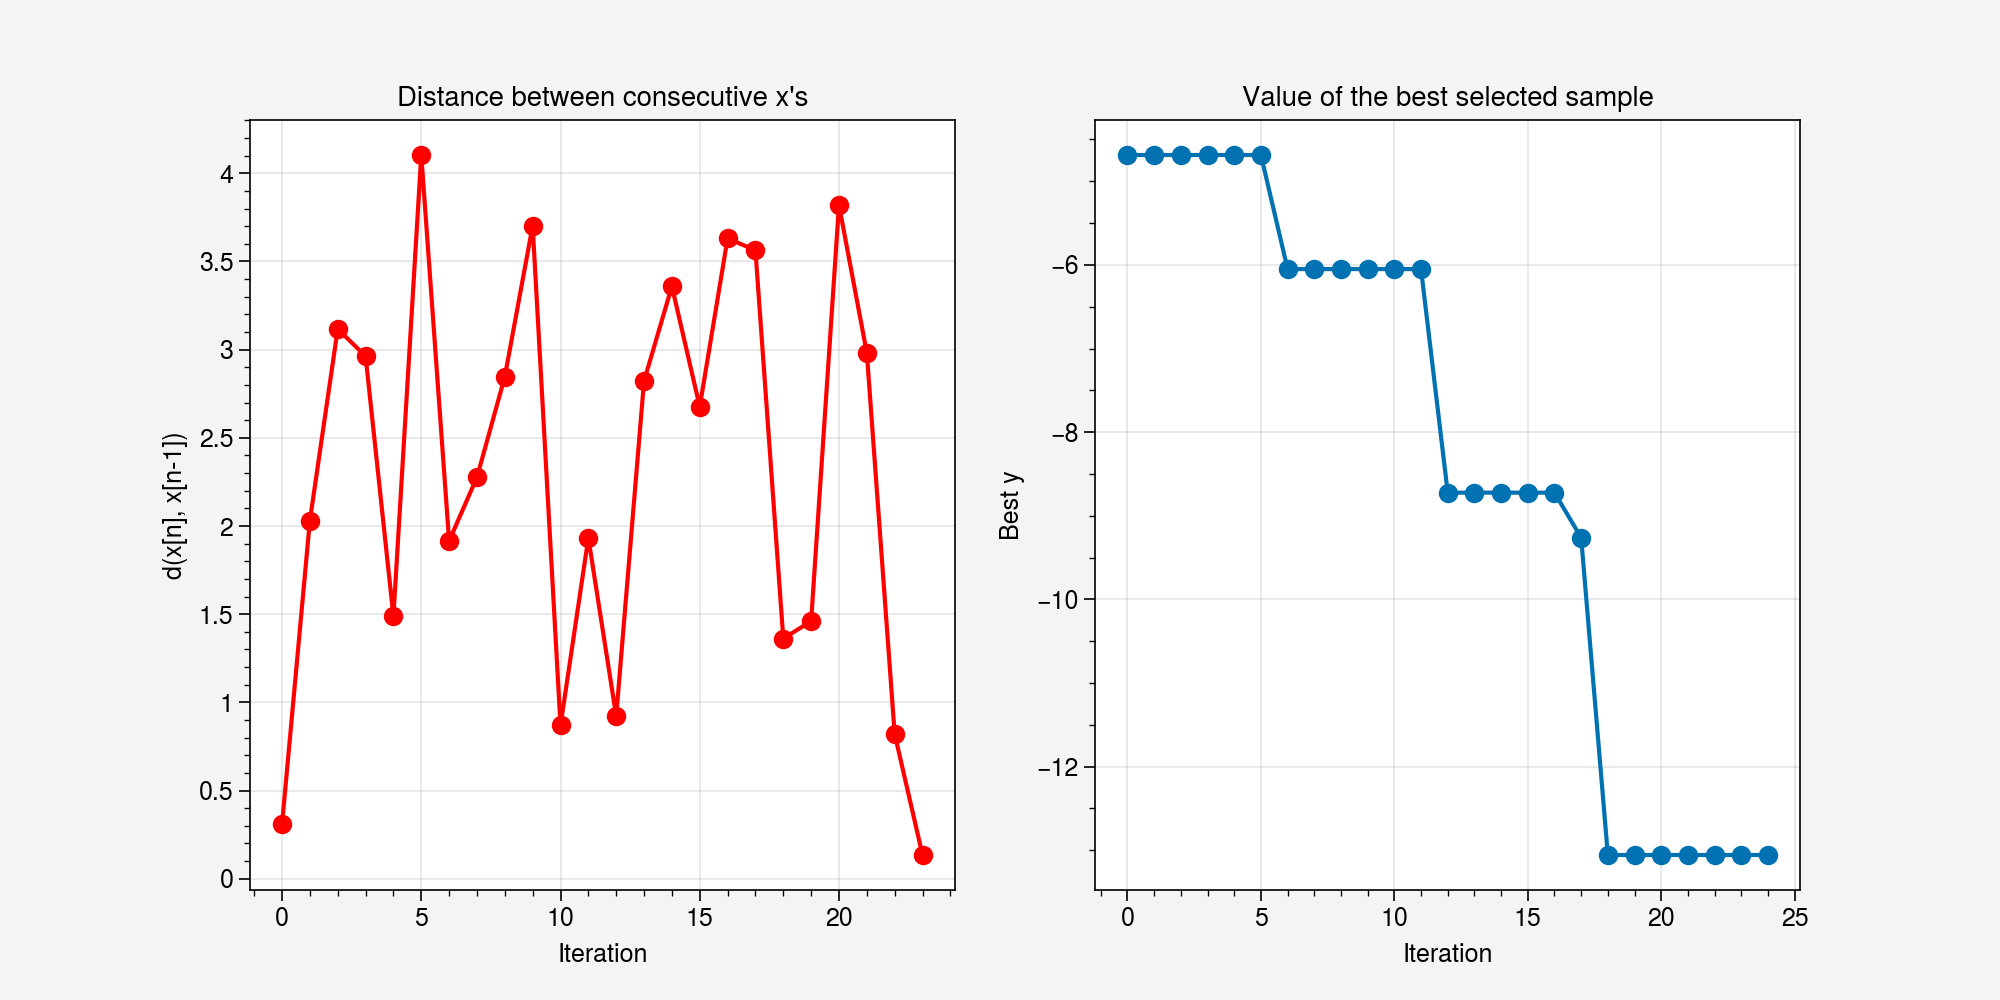

In [102]:
# it may take a few seconds
opt.run_optimization(max_iter=20)
opt.plot_convergence()

Let's show the best parameters found. They differ significantly from the default parameters.

In [103]:
optimal_hparams = opt.X[np.argmin(opt.Y)]
print(f"ls1: {str(optimal_hparams[0])}, ls2: {str(optimal_hparams[1])}, ls3: {str(optimal_hparams[2])}, v1: {str(optimal_hparams[3])}, v2: {str(optimal_hparams[4])}\n")

ls1: 3.8315612718518133, ls2: 0.4142596662560972, ls3: 0.6729013659155081, v1: 0.31893203448577845, v2: 0.5455182387168416



In [104]:
kernel = GPy.kern.RBF(1, lengthscale=optimal_hparams[0], variance=optimal_hparams[3]) + \
             GPy.kern.StdPeriodic(1, lengthscale=optimal_hparams[1]) * \
             GPy.kern.PeriodicMatern32(1, lengthscale=optimal_hparams[2], variance=optimal_hparams[4])

model = GPy.models.GPRegression(x_train.reshape(-1, 1), y_train.reshape(-1, 1), kernel=kernel, normalizer=True,
                                noise_var=0.05)
y_mean, y_std = model.predict(x_all.reshape(-1, 1))

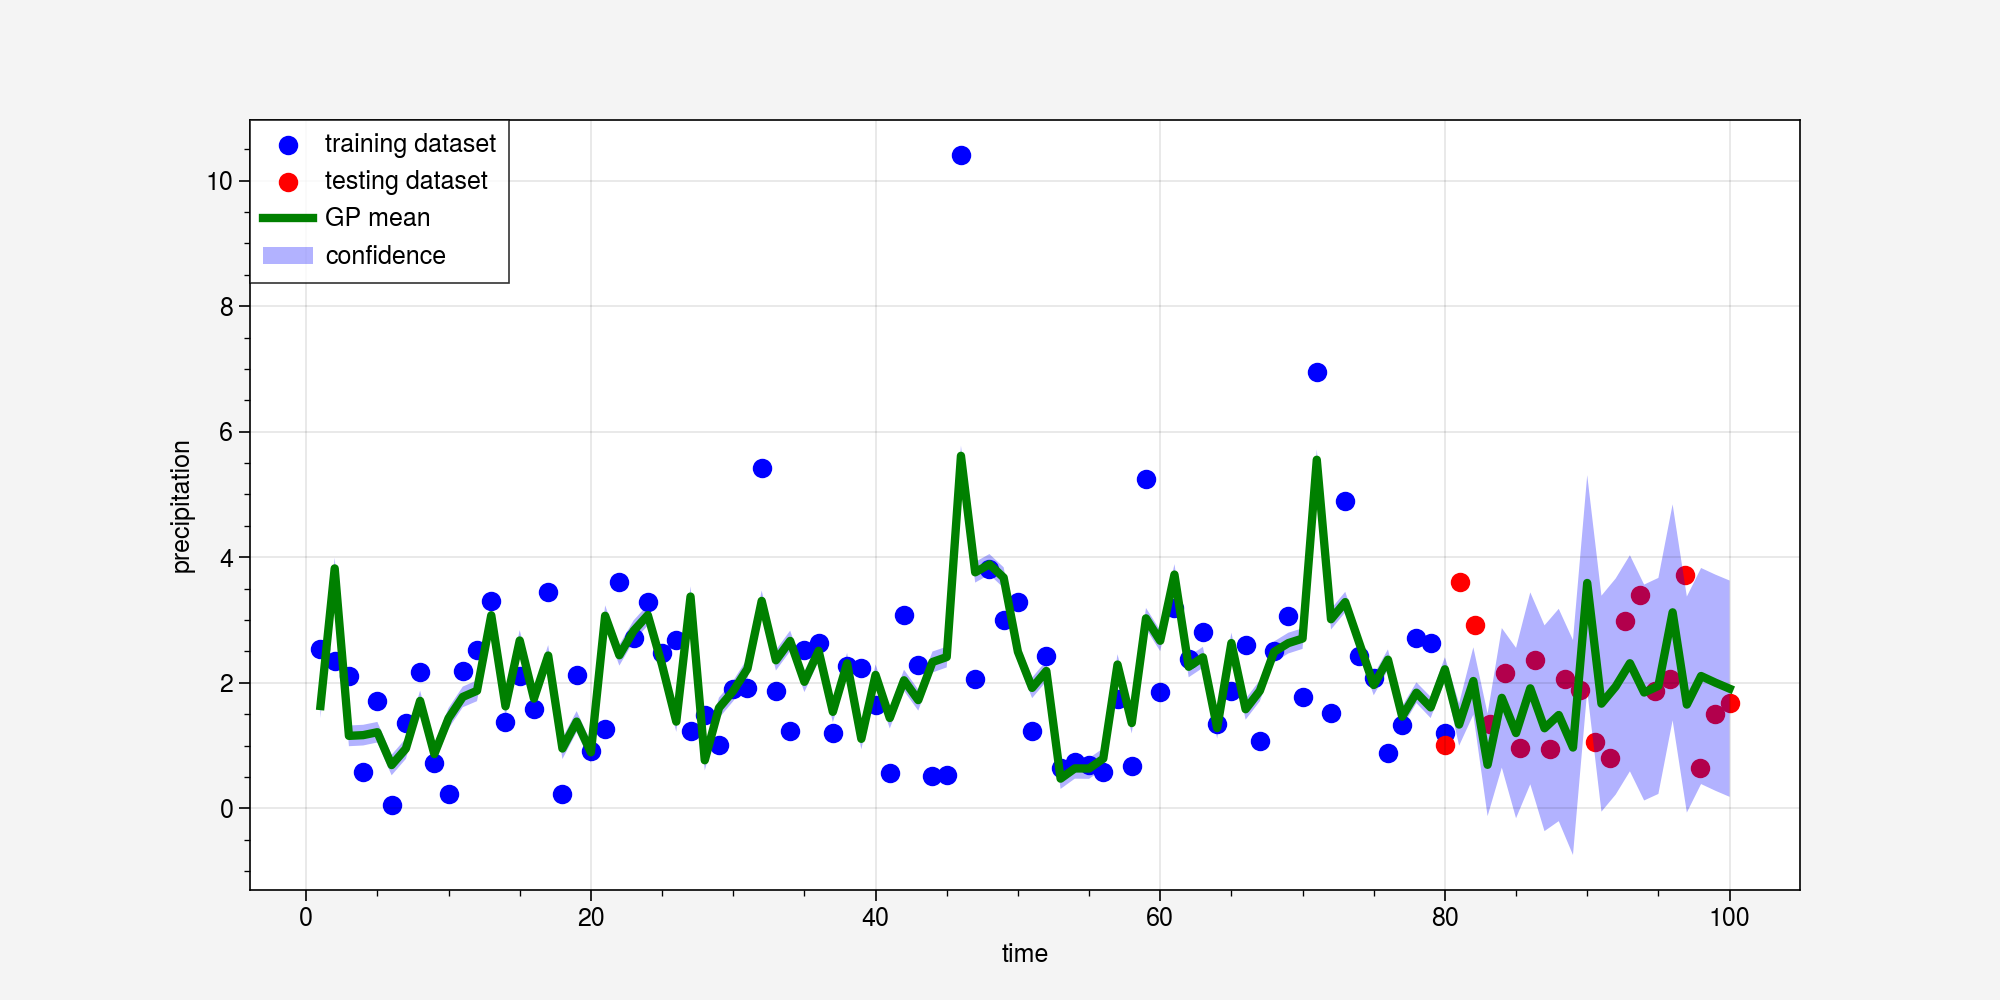

In [105]:
plt.figure(figsize=(10, 5), dpi=100)
plt.xlabel("time")
plt.ylabel("precipitation")
plt.scatter(x_train, y_train, lw=1, color="b", label="training dataset")
plt.scatter(x_test, y_test, lw=1, color="r", label="testing dataset")
plt.plot(x_all, y_mean, lw=3, color="g", label="GP mean")
plt.fill_between(x_all, (y_mean + y_std).reshape(y_mean.shape[0]), (y_mean - y_std).reshape(y_mean.shape[0]), facecolor="b", alpha=0.3, label="confidence")
plt.legend(loc="upper left")
plt.show()